FINAL DRAFT OF THIS 
Inputs: cdom files 
outputs: wavelenths.csv, plot.png, outputs.csv
    
    the only cells that need edits are at the top 
    they are labled "with edit here"
    
    Hanna Bridgham 
    3/30/2022


In [100]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import scipy.optimize
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy.interpolate import pchip_interpolate
import numpy as np
import math
from pandas import Series
from lmfit import Model, Parameter, report_fit
import scipy.ndimage
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from numpy import ones,vstack
from numpy.linalg import lstsq

In [101]:
#EDIT HERE
####################################
# This returns a list of names (strings) of files that have the .txt extension. 
# You should provide the path
files = glob.glob('../../../CDOM_DATA/GOM22SU/ABS_PW*/*.txt')
# You should add the path of your outputs 
path_1 = '../../../Data_Thesis/CDOM/SPECTRA/ABS_PW_GOM22SU_wavelenths.csv'
path_2 = "../../../Data_Thesis/CDOM/GRAPHS/ABS_PW_GOM22SU_plot.png"
path_3 = '../../../Data_Thesis/CDOM/OUTPUTS/ABS_PW_GOM22SU_outputs.csv'
files

['../../../CDOM_DATA/GOM22SU\\ABS_PW_GOM22SU_St.11_2252\\225200_Absorbance__0__58.txt',
 '../../../CDOM_DATA/GOM22SU\\ABS_PW_GOM22SU_St.11_2252\\225201_Absorbance__0__58.txt',
 '../../../CDOM_DATA/GOM22SU\\ABS_PW_GOM22SU_St.11_2252\\225201_Absorbance__1__59.txt',
 '../../../CDOM_DATA/GOM22SU\\ABS_PW_GOM22SU_St.11_2252\\225201_Absorbance__2__60.txt',
 '../../../CDOM_DATA/GOM22SU\\ABS_PW_GOM22SU_St.11_2252\\225202_Absorbance__0__61.txt',
 '../../../CDOM_DATA/GOM22SU\\ABS_PW_GOM22SU_St.11_2252\\225202_Absorbance__1__62.txt',
 '../../../CDOM_DATA/GOM22SU\\ABS_PW_GOM22SU_St.11_2252\\225202_Absorbance__2__63.txt',
 '../../../CDOM_DATA/GOM22SU\\ABS_PW_GOM22SU_St.11_2252\\225203_Absorbance__0__64.txt',
 '../../../CDOM_DATA/GOM22SU\\ABS_PW_GOM22SU_St.11_2252\\225203_Absorbance__1__65.txt',
 '../../../CDOM_DATA/GOM22SU\\ABS_PW_GOM22SU_St.11_2252\\225203_Absorbance__2__66.txt',
 '../../../CDOM_DATA/GOM22SU\\ABS_PW_GOM22SU_St.11_2252\\225204_Absorbance__0__67.txt',
 '../../../CDOM_DATA/GOM22SU\\AB

In [102]:
#EDIT HERE
####################################
#first Identify what wavegide was used then uncomment the correct waveguide 
X = .01 # 1 cm wg SN: , Basiclly antything from PW or RHZ
#X = .10 # 10 cm wg SN: , Basiclly antything from PW or RHZ
#X = .488 # 50 cm lwcc number 3 SN: , Basiclly antything from GOM22SP thats not PW
#X = .489 # 50 cm lwcc number 2 SN: , Basiclly antything from GOMFASP thats not PW

PART 1: GRAPHS AND WAVELENGTHS 

we use pchip to process the data to get the wavelenths in whole numbers 

we will save this to a output tabel 

we will also save the baseline correction 

In [103]:
#FINAL FUNTION 
#see above for the breakdown of diff parts 
def GET_CDOM_DATA(name):
    df = pd.read_csv(name, skiprows=14, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']*(2.303/X)
    #bcorr = df[(df['wl']>=700) & (df['wl']<=701)]['abs'].mean() # a float corection with just 700 nm 
    #bcorr = df[(df['wl']>=700) & (df['wl']<=750)]['abs'].mean() # a float corection with 700 to 750 nm 
    #df['abs'] = df['abs'] - bcorr
    x = df['wl']
    y = df['abs'] 
    pchip_obj1 = scipy.interpolate.PchipInterpolator(x, y, axis=0, extrapolate=None)
    xi = np.arange(189,881,1)
    yi = pchip_obj1(xi)
    d = {'wl': xi, 'abs': yi}
    df = pd.DataFrame(d)
    return df

In [109]:
#EDIT HERE
####################################
#MAKE IT ALL IN ONE EASY TO USE DATA FRAME 
#this makes a new data frame there all the columns are the scanns and the rows are the wavelths 
#edit the slpit function to get the abs names 
frames = []
for f in files:
    df = GET_CDOM_DATA(f) # runs the processing function 
    ID = f.split("\\")[2] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 
df

225200_Absorbance__0__58.txt  225201_Absorbance__0__58.txt  \
wl                                                                
189                     32.080790                      0.000000   
190                     32.080790                      0.000000   
191                     32.593777                     13.926715   
192                    -10.505585                     -3.379056   
193                      0.000000                      0.000000   
..                            ...                           ...   
876                      1.802717                      0.506104   
877                      2.667334                      1.054395   
878                     -0.762195                      1.823670   
879                      1.870503                      0.956235   
880                      3.140095                      3.365742   

     225201_Absorbance__1__59.txt  225201_Absorbance__2__60.txt  \
wl                                                                
189                     28.073570                    139.930280   
190                     28.073570                    139.930280   
191                     20.108118                     54.710856   
192                   -288.737481                    -13.852983   
193                      0.000000                    -79.824394   
..                            ...                           ...   
876                     -1.210282                      2.612412   
877                      3.777516                      1.758505   
878                      2.085086                      0.654431   
879                      1.108491                      0.995725   
880                      4.129518                      3.499270   

     225202_Absorbance__0__61.txt  225202_Absorbance__1__62.txt  \
wl                                                                
189                     23.951200                    252.316680   
190                     23.951200                    252.316680   
191                      0.274742                     18.356439   
192                    -10.358746                   -255.680848   
193                      0.000000                     35.991954   
..                            ...                           ...   
876                      1.253880                     -1.194230   
877                      3.350328                      0.692310   
878                     -0.236710                      1.404202   
879                      1.546323                      1.616966   
880                      4.424744                      2.477227   

     225202_Absorbance__2__63.txt  225203_Absorbance__0__64.txt  \
wl                                                                
189                      0.000000                    133.136430   
190                      0.000000                    133.136430   
191                      4.138437                     31.651680   
192                    -17.509904                    -38.718214   
193                    -60.978190                   -106.129013   
..                            ...                           ...   
876                      0.952470                      1.401292   
877                      1.675924                      1.160682   
878                      0.036173                     -0.065433   
879                      1.238347                      0.321890   
880                      5.585039                      2.758406   

     225203_Absorbance__1__65.txt  225203_Absorbance__2__66.txt  ...  \
wl                                                               ...   
189                     72.959040                     31.274740  ...   
190                     72.959040                     31.274740  ...   
191                     18.205992                     36.348059  ...   
192                     -7.538423                      0.000000  ...   
193                    -81.376246                      0.000000  ...   
..           

In [110]:
#EDIT HERE
####################################
#HERE WE ARE GOING TO AVERAGE THE SCANNS TO GET A VALUE FOR EACH WAVELENTH
#this filters eveything by all that have the work 'Absorbance' with anything after it 
#and turns it into a new object 
d = df.filter(regex='Absorbance*', axis=1)
#this splits the column names by 
#edit here to make the names a 6 diget number code 
names = d.columns.str.rsplit('_', n=5).str[0]
#this part groups evethign by the sample ID that we have in names then avarages all scanns regardless of how many there are 
df = d.groupby(names, axis=1).mean()
df

100_PPT_NaCl     224200     224201     224202     224203     224204  \
wl                                                                         
189     47.910077  94.000783  58.918417  57.812977  34.330053   0.000000   
190     47.910077  94.000783  58.918417  57.812977  34.330053   0.000000   
191    -37.555808 -33.909316  -9.900336  27.817250  45.126801   3.786170   
192     71.722185  50.108053  16.887360  10.139014  55.207412  52.094681   
193     11.468940 -20.496905  35.547850 -14.382039  44.831827  27.771729   
..            ...        ...        ...        ...        ...        ...   
876     -9.396211  -1.869603  -0.294150   0.652587   7.924769   4.473522   
877     -6.153097  -2.347727  -2.467058   3.036163   7.627421   5.728125   
878      5.682928  -2.826420  -0.967757   1.325494   9.082830   7.034492   
879     -8.138507  -4.397739  -3.598286   0.387500   6.635065   4.080151   
880     -6.745111   1.544422   2.819540   3.087868  10.911491   6.684576   

        224205      224206     224207     224208  ...      225313      225315  \
wl                                                ...                           
189  11.177227  202.487437 -22.815053   3.477530  ...  122.281623   56.907130   
190  11.177227  202.487437 -22.815053   3.477530  ...  122.281623   56.907130   
191 -29.106940   29.218077  -3.142136  17.012693  ...  -77.811429   -9.831749   
192   0.081973   45.945811 -14.916892  46.492776  ...  -62.254493 -102.060022   
193 -15.382799  143.410487  20.635509  24.959800  ...  114.190319   64.694171   
..         ...         ...        ...        ...  ...         ...         ...   
876   2.579417    2.605282  -2.753624   3.941018  ...   -0.102180    3.794054   
877   5.073999    8.507936   1.711312  10.440875  ...   -4.529297    0.172233   
878   4.792242    6.964608   1.272469   7.231171  ...   -0.883349    1.955914   
879   1.501072    9.492293   1.721290   9.356012  ...   -0.655438    3.302449   
880   6.878388    6.396012  -1.383734   5.340334  ...   -1.933410    1.821862   

        225316     225317     225318      225319     225320     225321  \
wl                                                                       
189  52.907587  26.684093  61.160003  115.364947  56.223907  27.566910   
190  52.907587  26.684093  61.160003  115.364947  56.223907  27.566910   
191 -89.010444 -26.711305   1.845762  -21.447932 -34.643061 -26.918949   
192 -32.213516 -10.097521  40.085428  144.241173  28.750619 -15.795779   
193  30.894527  28.854080  69.757067   48.709599  38.386395  13.493606   
..         ...        ...        ...         ...        ...        ...   
876   4.207978  10.908970  -1.607538   -0.566979   1.237454   3.280807   
877   1.133150   7.930880  -3.980959   -2.548115  -2.347008  -0.414277   
878   3.104772  11.267556  -2.221969    0.946069  -1.737215   1.882814   
879   3.744493  11.247968  -1.756251    0.196003   0.623269   3.292638   
880   2.693052  10.894042  -2.461119   -0.849186  -2.472241   1.150745   

        225322     225323  
wl                         
189   0.552720   0.000000  
190   0.552720   0.000000  
191 -77.193402 -24.205735  
192 -61.494712 -17.955570  
193  40.458874  60.018885  
..         ...        ...  
876  -0.441844   4.182193  
877  -5.396282   1.687798  
878  -2.182834   3.861978  
879  -1.933755   3.390835  
880  -3.033789   2.692493  

[692 rows x 231 columns]

In [111]:
#HERE WE DO THE BASLINE CORRECTION AND SAVE THE CORECTION AS 'bcorr'
bcorr = df[486:537].mean(axis=0) # 486:537 is 675 to 725 nm and this line takes the average 
df = df[:] - df[486:537].mean(axis=0) # here we correct the data by that average 
bcorr

100_PPT_NaCl   -3.644343
224200         -0.900409
224201         -1.717291
224202          1.162549
224203          8.980813
                  ...   
225319          1.840705
225320          2.063860
225321          5.262079
225322         -0.411040
225323          7.896800
Length: 231, dtype: float64

In [112]:
#HERE WE MAKE A COPY OF THE DATA THAT IS VERTICAL SO JB LIKES IT
Abs_data = df.transpose(copy=False)
Abs_data['bcorr'] = bcorr
Abs_data

#save it as a CSV to the propor location with the correct file name
Abs_data.to_csv(path_1)

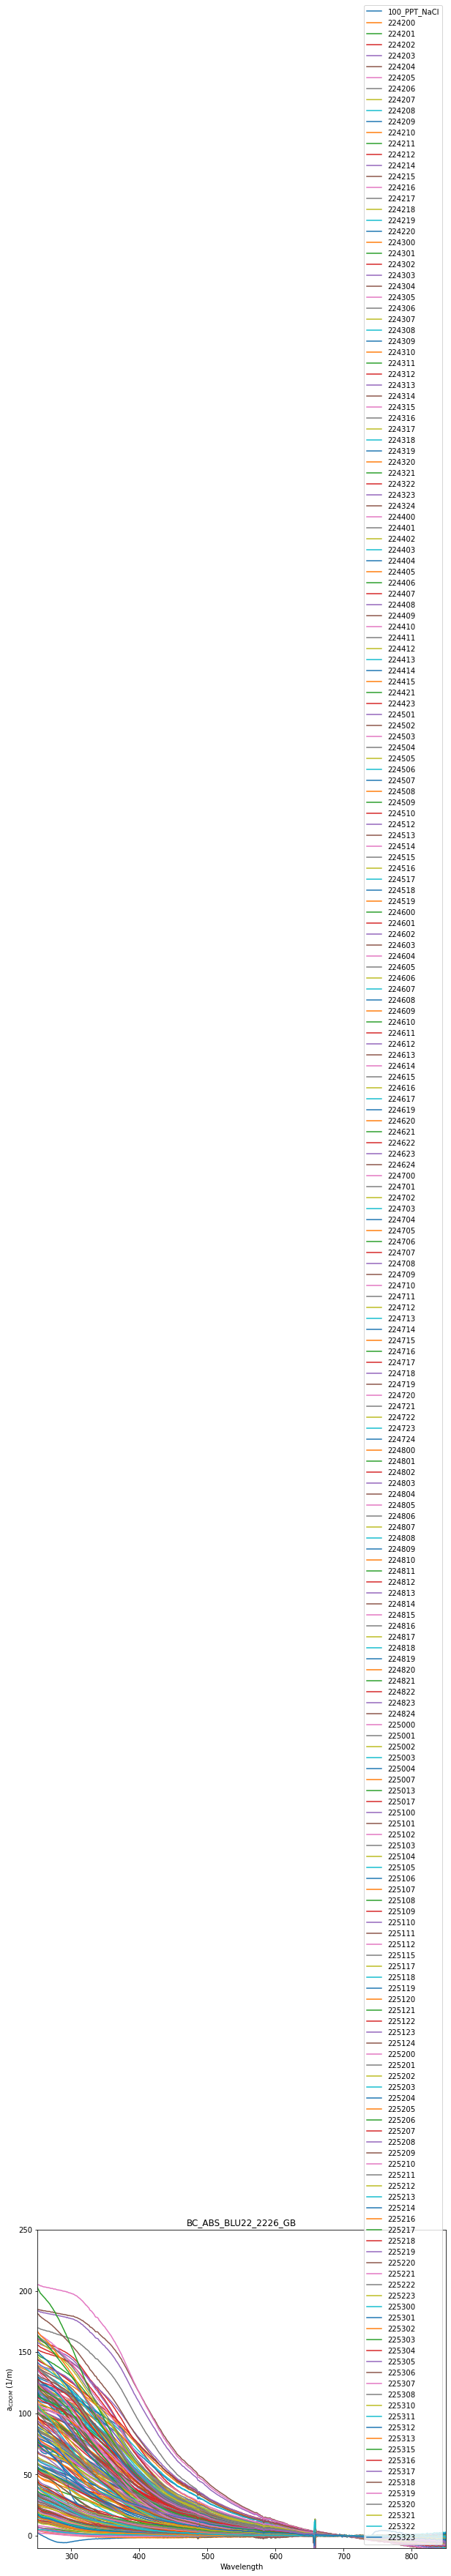

In [115]:
#HERE, WE MAKE A QUICK AND DIRTY GRAPH OF THE DATA TO SAVE AND CHECK WORK 
fig, ax = plt.subplots(figsize=(10,8))
df.plot(label='', ax=ax)
ax.set_ylim(-10,250)
ax.set_xlim(250,850)
ax.set_xlabel("Wavelength")
ax.set_ylabel("a$_{CDOM}$ (1/m)")
ax.set_title("BC_ABS_BLU22_2226_GB")

plt.savefig(path_2)

PART 2: REGRESSIONS

I need an output table for each sampling event with the sample number

we will get this with 2 regression methods 

there are two ways we are going to calculate the spectral slopes 
1. Single exponential (SEM) where: $A(g)=Ae^{slope}$
2. Hyperbolic (HM) where: $A(g)=A(\frac{wl}{532})^{slope}$

corresponding parameters = abs 254, abs 280, abs 320, abs 412, abs 444 

corresponding parameters = the spectral slope of 275 to 295, the spectral slope of 350 to 400, the spectral slope of 275 to 700

corresponding parameters = spectral ratio of spectral slope of 275 to 295 and the spectral slope of 350 to 400

corresponding parameters = baseline correction we used, so the b term 


In [116]:
#OPEN OUR FILES AND MAKE ABSORBANCE TO ABSORPTION
def open_file_abs_base_cor(name):
    df = pd.read_csv(name, skiprows=14, sep='\t', names=['wl', 'abs'], )
    df['abs'] = df['abs']*(2.303/X)
    return df

In [117]:
#EDIT HERE
####################################
#MAKE IT ALL IN ONE EASY TO USE DATA FRAME 
#this makes a new data frame there all the columns are the scanns and the rows are the wavelths 
frames = []
for f in files:
    df = open_file_abs_base_cor(f) # runs the processing function 
    ID = f.split("\\")[2] #takes junk out of the file name to make a single ID 
    df = df.rename(columns={'abs': ID}) # renames the abs col to the new id 
    df = df.set_index('wl', drop=True) # makes the wl the new index, aka the rows 
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=1, ignore_index=False) # adds all the things in the frame together to make a new df 

#HERE WE ARE GOING TO AVERAGE THE SCANNS TO GET A VALUE FOR EACH WAVELENTH 
d = df.filter(regex='Absorbance*', axis=1)
#this splits the column names by 
names = d.columns.str.rsplit('_', n=6).str[0]
#this part groups evethign by the sample ID that we have in names then avarages all scanns regardless of how many there are 
df = d.groupby(names, axis=1).mean()
df['wl'] = df.index
df

100_PPT     224200     224201      224202      224203     224204  \
wl                                                                             
189.2794  47.910077  94.000783  58.918417   57.812977   34.330053   0.000000   
189.6618  47.910077  94.000783  58.918417   57.812977   34.330053   0.000000   
190.0441  47.910077  94.000783  58.918417   57.812977   34.330053   0.000000   
190.4264   0.000000   0.000000   0.000000    0.000000   -4.698120  -7.361923   
190.8087  22.208597 -13.503257   0.000000  147.668360  143.691847  34.552677   
...             ...        ...        ...         ...         ...        ...   
880.5978  -6.647993  -0.161210  -1.519980   -0.545043    7.216067   5.972447   
880.8884 -12.428523  -3.984190  -2.579360    1.182207    8.298477   5.396697   
881.1790 -10.563093  -0.713930   0.207270   -1.159177    6.939707   3.623387   
881.4695 -10.563093  -0.713930   0.207270   -1.159177    6.939707   3.623387   
881.7600 -10.563093  -0.713930   0.207270   -1.159177    6.939707   3.623387   

             224205      224206      224207     224208  ...      225315  \
wl                                                      ...               
189.2794  11.177227  202.487437  -22.815053   3.477530  ...   56.907130   
189.6618  11.177227  202.487437  -22.815053   3.477530  ...   56.907130   
190.0441  11.177227  202.487437  -22.815053   3.477530  ...   56.907130   
190.4264  -2.817337   11.883480  103.304903  99.727577  ... -176.156470   
190.8087  46.589690   63.585830   39.335240  21.479313  ...   62.319180   
...             ...         ...         ...        ...  ...         ...   
880.5978   4.176107    8.052823    3.446823   9.611187  ...    2.464210   
880.8884   3.991867    9.242707    2.387443   8.912610  ...    1.366447   
881.1790   2.533300    8.060500    3.300967   8.674633  ...    1.681190   
881.4695   2.533300    8.060500    3.300967   8.674633  ...    1.681190   
881.7600   2.533300    8.060500    3.300967   8.674633  ...    1.681190   

              225316      225317      225318      225319      225320  \
wl                                                                     
189.2794   52.907587   26.684093   61.160003  115.364947   56.223907   
189.6618   52.907587   26.684093   61.160003  115.364947   56.223907   
190.0441   52.907587   26.684093   61.160003  115.364947   56.223907   
190.4264 -219.491253 -232.096340 -271.162897 -221.679103 -164.856417   
190.8087   23.314037   42.075810   92.757163  147.092610   67.001947   
...              ...         ...         ...         ...         ...   
880.5978    5.151043   11.192580   -0.284037    0.330097   -1.489273   
880.8884    1.988257   11.645503   -3.953483   -1.834723   -0.092120   
881.1790    3.531267   10.808747   -2.387443   -0.575750   -0.798373   
881.4695    3.531267   10.808747   -2.387443   -0.575750   -0.798373   
881.7600    3.531267   10.808747   -2.387443   -0.575750   -0.798373   

              225321      225322      225323        wl  
wl                                                      
189.2794   27.566910    0.552720    0.000000  189.2794  
189.6618   27.566910    0.552720    0.000000  189.6618  
190.0441   27.566910    0.552720    0.000000  190.0441  
190.4264 -191.947373 -146.739483 -199.048290  190.4264  
190.8087   34.759947   38.337273   89.210543  190.8087  
...              ...         ...         ...       ...  
880.5978    1.020997   -1.857753    5.757500  880.5978  
880.8884    1.189883   -2.579360    4.314287  880.8884  
881.1790    1.020997   -4.621353    5.864973  881.1790  
881.4695    1.020997   -4.621353    5.864973  881.4695  
881.7600    1.020997   -4.621353    5.864973  881.7600  

[2048 rows x 232 columns]

In [118]:
#EXPONENTAL REGRESSION A(g)=Ae^slope
def exp_equation(x, a, s, b):
    return a * np.exp(-s * x) + b

In [119]:
#HERE DO THE WHOLE EXPO AS A LOOP FOR ALL SAMPLES 
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    #get the x and y values for all the slope intervals we want 
    ydata_s700 = df[(df['wl']>=275) & (df['wl']<=700)][col]
    xdata_s700 = df[(df['wl']>=275) & (df['wl']<=700)]['wl']
    ydata_s700 = np.asarray(ydata_s700, dtype=float).ravel()
    xdata_s700 = np.asarray(xdata_s700, dtype=float).ravel()
    ydata_s295 = df[(df['wl']>=275) & (df['wl']<=295)][col]
    xdata_s295 = df[(df['wl']>=275) & (df['wl']<=295)]['wl']
    ydata_s295 = np.asarray(ydata_s295, dtype=float).ravel()
    xdata_s295 = np.asarray(xdata_s295, dtype=float).ravel()
    ydata_s350 = df[(df['wl']>=350) & (df['wl']<=400)][col]
    xdata_s350 = df[(df['wl']>=350) & (df['wl']<=400)]['wl']
    ydata_s350 = np.asarray(ydata_s350, dtype=float).ravel()
    xdata_s350 = np.asarray(xdata_s350, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams_700 = (15, .001, 0)
    pams_295 = (10, .001, 0)
    pams_350 = (10, .001, 0)
    
    #regression exp_equation 275 to 700
    params, cv = curve_fit(exp_equation, xdata_s700, ydata_s700, p0=pams_700, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 275 to 700 and calcuate rSquared
    squaredDiffs = np.square(ydata_s700 - exp_equation(xdata_s700, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s700 - np.mean(ydata_s700))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_700 = rSquared
    ss_275_700 = s
    
    #get the waveleths we need
    abs_254 = exp_equation(252, a, s, b)
    abs_280 = exp_equation(280, a, s, b)
    abs_320 = exp_equation(320, a, s, b)
    abs_350 = exp_equation(350, a, s, b)
    abs_412 = exp_equation(412, a, s, b)
    abs_440 = exp_equation(440, a, s, b)
    
    #regression exp_equation 275 to 295
    params, cv = curve_fit(exp_equation, xdata_s295, ydata_s295, p0=pams_295, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 270 to 295 and calcuate rSquared
    squaredDiffs = np.square(ydata_s295 - exp_equation(xdata_s295, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s295 - np.mean(ydata_s295))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_295 = rSquared
    ss_275_295 = s
    
    #regression exp_equation 350 to 400
    params, cv = curve_fit(exp_equation, xdata_s350, ydata_s350, p0=pams_350, maxfev=maxfev)
    a, s, b = params
    
    #get the valuse for exp_equation 350 to 400 and calcuate rSquared
    squaredDiffs = np.square(ydata_s350 - exp_equation(xdata_s350, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s350 - np.mean(ydata_s350))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_350_400 = rSquared
    ss_350_400 = s 
    
    #get the spectral ratio 
    sr = ss_275_295 / ss_350_400
    
    dict = {'sample':[columnName],
        'ss_275_700_SEM':[ss_275_700],
        'ss_275_295_SEM':[ss_275_295],
        'ss_350_400_SEM':[ss_350_400],
        'R2_275_700':[R2_275_700],
        'R2_275_295':[R2_275_295],
        'R2_350_400':[R2_350_400],
        'SR_SEM':[sr],
        'abs_254_SEM':[abs_254], 
        'abs_280_SEM':[abs_280],
        'abs_320_SEM':[abs_320], 
        'abs_350_SEM':[abs_350],
        'abs_412_SEM':[abs_412], 
        'abs_440_SEM':[abs_440]}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [120]:
#HERE WE TEST TO MAKE SURE THE R SQAURED IS GOOD 
#this will let us know if something is wrong and where 

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

R_level = .95 #set x to the r2 value you want to test

min_1 = ss_outs['R2_275_700'].min()
min_2 = ss_outs['R2_275_295'].min()
min_3 = ss_outs['R2_350_400'].min()

if min_1 < R_level: 
    print("!!! WARNING !!! 275_700 has a bad R2 !!!")
if min_2 < R_level:
    print("!!! WARNING !!! 275_295 has a bad R2 !!!")
if min_3 < R_level:
    print("!!! WARNING !!! 350_400 has a bad R2 !!!")
else: 
    print("THE FITS ARE GOOD, YAY!")
    
ss_outs.loc[ss_outs.R2_275_700 < R_level, 'ss_275_700_SEM'] = np.nan
ss_outs.loc[ss_outs.R2_275_295 < R_level, 'ss_275_295_SEM'] = np.nan
ss_outs.loc[ss_outs.R2_350_400 < R_level, 'ss_350_400_SEM'] = np.nan
    
#HERE WE SAME THE SLOPE VALUES 
ss_275_700_SEM = ss_outs['ss_275_700_SEM']
ss_275_295_SEM = ss_outs['ss_275_295_SEM']
ss_350_400_SEM = ss_outs['ss_350_400_SEM']
abs_254_SEM = ss_outs['abs_254_SEM']
abs_280_SEM = ss_outs['abs_280_SEM']
abs_320_SEM = ss_outs['abs_320_SEM']
abs_412_SEM = ss_outs['abs_412_SEM']
abs_440_SEM = ss_outs['abs_440_SEM']
SR_SEM = ss_outs['SR_SEM']

!!! WARNING !!! 275_700 has a bad R2 !!!
!!! WARNING !!! 275_295 has a bad R2 !!!
!!! WARNING !!! 350_400 has a bad R2 !!!


In [121]:
#HYPERBOLIC REGRESSION A(g)=A(wl/532)^slope
def hyp_equation(x, a, s, b):
    return a * ((x/532)**-s) + b

In [122]:
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    #get the x and y values for all the slope intervals we want 
    #get the x and y values for all the slope intervals we want 
    ydata_s700 = df[(df['wl']>=275) & (df['wl']<=700)][col]
    xdata_s700 = df[(df['wl']>=275) & (df['wl']<=700)]['wl']
    ydata_s700 = np.asarray(ydata_s700, dtype=float).ravel()
    xdata_s700 = np.asarray(xdata_s700, dtype=float).ravel()
    ydata_s295 = df[(df['wl']>=275) & (df['wl']<=295)][col]
    xdata_s295 = df[(df['wl']>=275) & (df['wl']<=295)]['wl']
    ydata_s295 = np.asarray(ydata_s295, dtype=float).ravel()
    xdata_s295 = np.asarray(xdata_s295, dtype=float).ravel()
    ydata_s350 = df[(df['wl']>=350) & (df['wl']<=400)][col]
    xdata_s350 = df[(df['wl']>=350) & (df['wl']<=400)]['wl']
    ydata_s350 = np.asarray(ydata_s350, dtype=float).ravel()
    xdata_s350 = np.asarray(xdata_s350, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams_700 = (.001, 11, 0)
    pams_295 = (1, 0, 1)
    pams_350 = (1, 1, 1)
    
    maxfev = 1000000
    
    #regression exp_equation 275 to 700
    params, cv = curve_fit(hyp_equation, xdata_s700, ydata_s700, p0=pams_700, maxfev=maxfev)
    a, s, b = params
    
    #print out for exp_equation 275 to 700 and calcuate rSquared
    squaredDiffs = np.square(ydata_s700 - hyp_equation(xdata_s700, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s700 - np.mean(ydata_s700))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_700 = rSquared
    ss_275_700 = s
    
    #get the waveleths we need
    abs_254 = hyp_equation(252, a, s, b)
    abs_280 = hyp_equation(280, a, s, b)
    abs_320 = hyp_equation(320, a, s, b)
    abs_350 = hyp_equation(350, a, s, b)
    abs_412 = hyp_equation(412, a, s, b)
    abs_440 = hyp_equation(440, a, s, b)
    
    #regression exp_equation 275 to 295
    params, cv = curve_fit(hyp_equation, xdata_s295, ydata_s295, p0=pams_295, maxfev=maxfev)
    a, s, b = params
    
    #print out for exp_equation 270 to 295 and calcuate rSquared
    squaredDiffs = np.square(ydata_s295 - hyp_equation(xdata_s295, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s295 - np.mean(ydata_s295))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_275_295 = rSquared
    ss_275_295 = s
    
    #regression exp_equation 350 to 400
    params, cv = curve_fit(hyp_equation, xdata_s350, ydata_s350, p0=pams_350, maxfev=maxfev)
    a, s, b = params
    
    #print out for exp_equation 350 to 400 and calcuate rSquared
    squaredDiffs = np.square(ydata_s350 - hyp_equation(xdata_s350, a, s, b))
    squaredDiffsFromMean = np.square(ydata_s350 - np.mean(ydata_s350))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    R2_350_400 = rSquared
    ss_350_400 = s 
    
    #get the spectral ratio 
    sr = ss_275_295 / ss_350_400
    
    dict = {'sample':[columnName],
        'ss_275_700_HM':[ss_275_700],
        'ss_275_295_HM':[ss_275_295],
        'ss_350_400_HM':[ss_350_400],
        'R2_275_700':[R2_275_700],
        'R2_275_295':[R2_275_295],
        'R2_350_400':[R2_350_400],
        'SR_HM':[sr],
        'abs_254_HM':[abs_254], 
        'abs_280_HM':[abs_280],
        'abs_320_HM':[abs_320], 
        'abs_350_HM':[abs_350],
        'abs_412_HM':[abs_412], 
        'abs_440_HM':[abs_440]}
    ss_outs = pd.DataFrame(dict)
    ss_outs = ss_outs.set_index('sample', drop=True)
    Frames.append(ss_outs)

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

In [123]:
#HERE WE TEST TO MAKE SURE THE R SQAURED IS GOOD 
#this will let us know if something is wrong and where 

ss_outs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
ss_outs = ss_outs.drop('wl')

R_level = .95 #set x to the r2 value you want to test

min_1 = ss_outs['R2_275_700'].min()
min_2 = ss_outs['R2_275_295'].min()
min_3 = ss_outs['R2_350_400'].min()

if min_1 < R_level: 
    print("!!! WARNING !!! 275_700 has a bad R2 !!!")
if min_2 < R_level:
    print("!!! WARNING !!! 275_295 has a bad R2 !!!")
if min_3 < R_level:
    print("!!! WARNING !!! 350_400 has a bad R2 !!!")
else: 
    print("THE FITS ARE GOOD, YAY!")

ss_outs.loc[ss_outs.R2_275_700 < R_level, 'ss_275_700_HM'] = np.nan
ss_outs.loc[ss_outs.R2_275_295 < R_level, 'ss_275_295_HM'] = np.nan
ss_outs.loc[ss_outs.R2_350_400 < R_level, 'ss_350_400_HM'] = np.nan
    
    
#HERE WE SAME THE SLOPE VALUES 
ss_275_700_HM = ss_outs['ss_275_700_HM']
ss_275_295_HM = ss_outs['ss_275_295_HM']
ss_350_400_HM = ss_outs['ss_350_400_HM']
abs_254_HM = ss_outs['abs_254_HM']
abs_280_HM = ss_outs['abs_280_HM']
abs_320_HM = ss_outs['abs_320_HM']
abs_412_HM = ss_outs['abs_412_HM']
abs_440_HM = ss_outs['abs_440_HM']
SR_HM = ss_outs['SR_HM']

!!! WARNING !!! 275_700 has a bad R2 !!!
!!! WARNING !!! 275_295 has a bad R2 !!!
!!! WARNING !!! 350_400 has a bad R2 !!!


PART 3: MAKE ESTIMATE OF INFLECTION 

So at a lot of these there is an infection at around 350 nm 

We need a way to estimate that inflection 

we are going to look for inflections between 300 and 400 nm and quantify them 


In [124]:
#EXPONENTAL REGRESSION A(g)=Ae^slope
def exp_equation(x, a, s, b):
    return a * np.exp(-s * x) + b

In [125]:
#HERE WE FIND THE INTIGRAL OF ALL THE SAMPLE FOR 350 INFLECTION 
Frames = []
maxfev = 10000000
for (columnName, columnData) in df.iteritems():
    col = columnName
    #define where we expect to find the inflection 
    ydata = df[(df['wl']>=300) & (df['wl']<=400)][col]
    xdata = df[(df['wl']>=300) & (df['wl']<=400)]['wl']
    ydata = np.asarray(ydata, dtype=float).ravel()
    xdata = np.asarray(xdata, dtype=float).ravel()
    
    #here we take evething not in the infelction for the abs data
    ydata_r1 = df[(df['wl']>=250) & (df['wl']<=300)][col]
    ydata_r2 = df[(df['wl']>=400) & (df['wl']<=700)][col]
    ydata_r = pd.concat([ydata_r1, ydata_r2], axis=0)
    
    #here we take evething not in the infelction for the wl data
    xdata_r1 = df[(df['wl']>=250) & (df['wl']<=300)]['wl']
    xdata_r2 = df[(df['wl']>=400) & (df['wl']<=700)]['wl']
    xdata_r = pd.concat([xdata_r1, xdata_r2], axis=0)
    
    #here we make them both arrays so we can doo math 
    ydata_r = np.asarray(ydata_r, dtype=float).ravel()
    xdata_r = np.asarray(xdata_r, dtype=float).ravel()
    
    #set some innital guesses to the curve fit 
    pams = (1, .001, 0)
    
    #here we do an expodental fit for just the data where we expect there to de no inflection 
    #aka, what the regression would be without the inflection 
    params, cv = curve_fit(exp_equation, xdata_r, ydata_r, p0=pams, maxfev = maxfev)
    a, s, b = params
    
    #here we calculate the R squared of that regressions fit 
    squaredDiffs = np.square(ydata_r - exp_equation(xdata_r, a, s, b))
    squaredDiffsFromMean = np.square(ydata_r - np.mean(ydata_r))
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    
    #here we take the differance of the accual data and the regressions fit that dident have that data 
    diffs = ydata - exp_equation(xdata, a, s, b)
    
    #here we normalize the data 
    diffs = (diffs - np.min(diffs)) / (np.max(diffs) - np.min(diffs))
    
    #here we flaten the data
    y1 = xdata[0]
    y2 = xdata[273]
    x1 = diffs[0]
    x2 = diffs[273]
    m = (x2 - x1)/(y2 - y1)
    mx = m * y1
    b = x1 - mx
    
    diffs = diffs - ((m*xdata)+b)
    
    #here we calculate the intigral 
    inter = scipy.integrate.simps(ydata, x=diffs, even='avg')
    
    #plt.plot(xdata, diffs, 'ko', label='data')
    #plt.plot(xdata, gauss(xdata, *gauss_fit(xdata, diffs)), '--r', label='fit')
    #plt.show()
    #print('The offset of the gaussian baseline is', gaus_baseline)
    #print('The center of the gaussian fit is', center_gaus)
    #print('The sigma of the gaussian fit is', sigma)
    #print('The maximum intensity of the gaussian fit is', H + A)
    #print('The Amplitude of the gaussian fit is', A)
    #print('The FWHM of the gaussian fit is', FWHM)
    
    #here we define some columns for a new data frame with the sample, the R2, and the diffs intigral 
    dict = {'sample':[columnName],
        '350_intergration':[inter],
        'R2':[rSquared]}
    diff = pd.DataFrame(dict)
    
    #here we set the index and append the data together 
    diffs = diff.set_index('sample', drop=True)
    Frames.append(diffs) # adds the new col from each scan to a part of frames 
    
    
diffs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
diffs = diffs.drop('wl') # drops the wl col 

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\optimize\_minpack_py.py:

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\optimize\_minpack_py.py:

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\optimize\_minpack_py.py:

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\scipy\optimize\_minpack_py.py:

In [126]:
#HERE WE TEST TO MAKE SURE THE R SQAURED IS GOOD 
#this will let us know if something is wrong and where 

diffs = pd.concat(Frames, axis=0, ignore_index=False) # adds all the things in the frame together to make a new df 
diffs = diffs.drop('wl') # drops the wl col 

R_level = .95 #set x to the r2 value you want to test

min_1 = diffs['R2'].min()

if min_1 < R_level: 
    print("!!! WARNING !!! 275_700 has a bad R2 !!!")
else: 
    print("THE FITS ARE GOOD, YAY!")

diffs.loc[diffs.R2 < R_level, '350_intergration'] = np.nan

!!! WARNING !!! 275_700 has a bad R2 !!!


In [127]:
#NOW WE SAVE ALL THE VALUSE WE WANTED TO A TABEL 
outputs = pd.concat([ss_275_700_SEM, ss_275_295_SEM, ss_350_400_SEM,
                    ss_275_700_HM, ss_275_295_HM, ss_350_400_HM,
                    abs_254_SEM, abs_280_SEM, abs_320_SEM, abs_412_SEM, abs_440_SEM,
                    abs_254_HM, abs_280_HM, abs_320_HM, abs_412_HM, abs_440_HM,
                    SR_SEM, SR_HM], axis=1)
#outputs = outputs.rename(columns={0: 'baseline_correction', 1: 'abs_254',
#                                  2: 'abs_280', 3: 'abs_320', 4: 'abs_412', 5: 'abs_444'})
outputs['350_intergration'] = diffs['350_intergration']
#SAVE IT 
outputs.to_csv(path_3)
outputs

ss_275_700_SEM  ss_275_295_SEM  ss_350_400_SEM  ss_275_700_HM  \
sample                                                                   
100_PPT             NaN             NaN             NaN            NaN   
224200              NaN        0.018620             NaN            NaN   
224201         0.016282        0.009743        0.013308       5.137910   
224202         0.009286        0.006397        0.004425       2.766517   
224203         0.006752        0.000024        0.000205       1.810779   
...                 ...             ...             ...            ...   
225319         0.009813        0.004447        0.005948       2.986531   
225320         0.009943        0.000544        0.007004       3.034581   
225321         0.009690        0.000353        0.009280       2.946750   
225322         0.013692        0.003881        0.013759       4.294810   
225323         0.010371             NaN        0.010856       3.185460   

         ss_275_295_HM  ss_350_400_HM  abs_254_SEM  abs_280_SEM  abs_320_SEM  \
sample                                                                         
100_PPT            NaN            NaN   -10.633485    -9.004066    -7.226362   
224200        4.297118            NaN     6.415133     1.964910    -0.302922   
224201        1.778720       3.953421    17.552044    10.470643     4.602573   
224202        0.815385       0.634235    46.265871    35.620944    24.498650   
224203        0.005396       0.002069   102.806834    85.419599    65.645309   
...                ...            ...          ...          ...          ...   
225319        0.271849       1.222972    40.157193    30.856899    21.308701   
225320        0.005675       1.618200    44.003916    33.732986    23.233860   
225321        0.004971       2.467443    64.287540    50.163207    35.602932   
225322        0.106338       4.139540    39.348541    26.691617    15.267651   
225323        0.006807       3.057466    86.659582    66.782090    46.751032   

         abs_412_SEM  abs_440_SEM  abs_254_HM  abs_280_HM  abs_320_HM  \
sample                                                                  
100_PPT    -4.769465    -4.315882  -11.234751   -9.157973   -7.169901   
224200     -1.161000    -1.190853    7.746436    2.008769   -0.334455   
224201     -0.360459    -0.883736   19.916596   10.749854    4.414261   
224202     10.295658     7.886500   49.565782   36.237658   24.073206   
224203     36.138190    30.235714  107.347456   86.370116   64.935226   
...              ...          ...         ...         ...         ...   
225319      9.498843     7.564064   43.378785   31.515823   20.965712   
225320     10.349438     8.256706   47.589614   34.464603   22.857975   
225321     17.459563    14.462952   69.237357   51.202841   35.088839   
225322      4.046884     2.631302   43.651818   27.327201   14.876529   
225323     22.796216    19.014569   93.656874   68.176339   46.040199   

         abs_412_HM  abs_440_HM     SR_SEM     SR_HM  350_intergration  
sample                                                                  
100_PPT   -4.760183   -4.335646  69.932816 -0.010735               NaN  
224200    -1.142286   -1.178236   0.712316  0.493471          0.126886  
224201    -0.257726   -0.760624   0.732119  0.449919          0.473341  
224202    10.382256    8.132109   1.445837  1.285621          5.709027  
224203    36.161054   30.594907   0.117971  2.607998               NaN  
...             ...         ...        ...       ...               ...  
225319     9.558275    7.753595   0.747684  0.222285         -2.978410  
225320    10.417263    8.465504   0.077697  0.003507         -2.975433  
225321    17.538860   14.743155   0.038092  0.002015               NaN  
225322     4.230472    2.894414   0.282066  0.025688         -1.472862  
225323    22.953682   19.425868  32.385996  0.002226               NaN  

[231 rows x 19 columns]